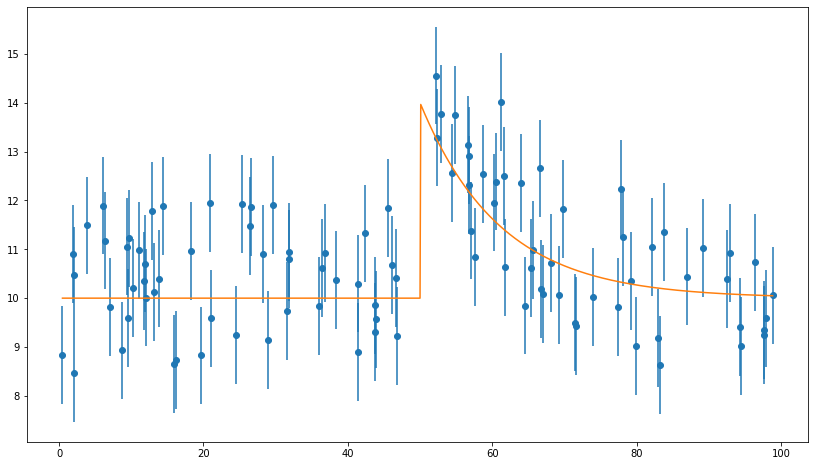

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

data = np.load('transient.npy')

time, flux, f_unc = data.T

plt.figure(figsize = (14, 8))
plt.errorbar(time, flux, yerr = f_unc, linestyle = 'none')
plt.scatter(time, flux)


def sharp_burst(x, arr):
    b, A, alpha, t0 = arr
    return np.where(x < t0, b, b + A*np.exp(-alpha*(x-t0)))

initial_guess = np.array([10, 4, 0.09, 50])

x_axis = np.linspace(time.min(), time.max(), 1000)
plt.plot(x_axis, sharp_burst(x_axis, initial_guess))

In [117]:
def logLikelihood(arr, data, model):
    x, y, sigma_y = data.T
    model_y = model(x, arr)
    return -0.5 * np.sum((y-model_y)**2/sigma_y**2)

#generating priors:
#suggestion is to use uniform distros, but I'm lazy and I just googled "how to fit with emcee" and
#I found an interesting page where they use uniformative uniform distros as priors, just as what
#am I asked to do LOL, so I just copyed what they did there: 
#https://emcee.readthedocs.io/en/stable/tutorials/line/

#p.s. I found out in solutions that prof. Gerosa gave us that he suggested us the same web page I found
#cuz of my laziness...

def log_prior(arr):
    b, A, alpha, t0 = arr
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t0 < 100.0 and -5 < np.log(alpha) < 5:
        return 0.0
    return -np.inf    

def log_probability(arr, data, model):
    lp = log_prior(arr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(arr, data, model)

In [154]:
#emcee sampling
import emcee

ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
#burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

starting_guesses = initial_guess + np.random.randn(nwalkers, ndim)

In [155]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (data, sharp_burst))
sampler.run_mcmc(starting_guesses, nsteps);

<ipython-input-117-ef59a5c5ba14>:16: RuntimeWarning: invalid value encountered in log
  if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t0 < 100.0 and -5 < np.log(alpha) < 5:
/home/jacopo/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


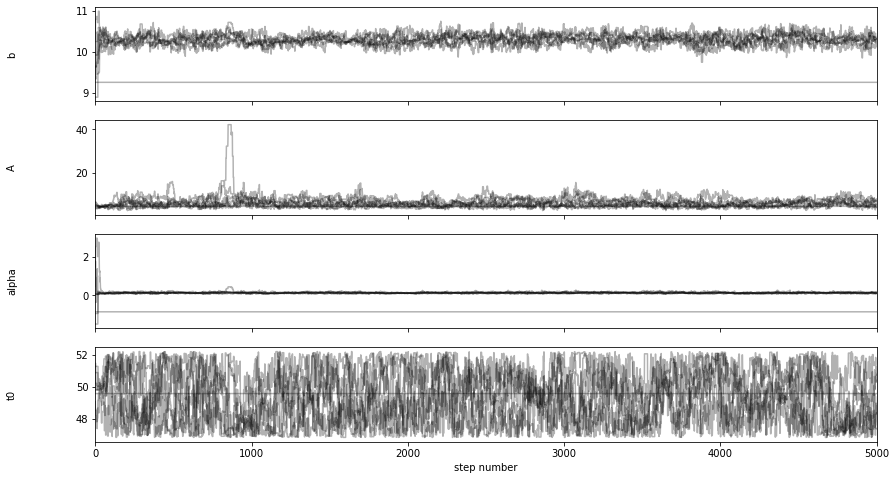

In [156]:
fig, axes = plt.subplots(4, figsize=(14, 8), sharex=True)
samples = sampler.get_chain()
labels = ["b", "A", "alpha", "t0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");